In [1]:
library(DESeq2)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges


Load the files, see what they look like

In [2]:
#This file is the AdRp file, with columns with counts less than 500000 removed, and with rows with rDNA or MtDNA removed
damid<-read.csv("AdRp_noMtDNA")
loc<-read.csv("Locations")
metadata<-read.csv("file_names")

In [3]:
head(loc)
length(loc)

,X,X0,X1,X2
1,0,211000022278049,390,394
2,1,211000022278049,537,541
3,2,211000022278049,573,577
4,3,211000022278049,837,841
5,4,211000022278049,1613,1617
6,5,211000022278049,1618,1622


[1] 4

have new locations list

In [4]:
loc=paste(loc$X0, ":", loc$X1, "-", loc$X2, sep="")

In [5]:
head(loc)

[1] "211000022278049:390-394"   "211000022278049:537-541"  
[3] "211000022278049:573-577"   "211000022278049:837-841"  
[5] "211000022278049:1613-1617" "211000022278049:1618-1622"

In [6]:
head(metadata)

,X,Rep,Tissue,Country,Line,NotSureProtein,protein
1,damID-Dam_Fr188_C1,1,C,Fr,188,damID,Dam
2,damID-Dam_Fr188_C2,2,C,Fr,188,damID,Dam
3,damID-Dam_Fr188_C3,3,C,Fr,188,damID,Dam
4,damID-Dam_Fr188_C4,4,C,Fr,188,damID,Dam
5,damID-Dam_Fr188_T3,3,T,Fr,188,damID,Dam
6,damID-Dam_Fr188_T4,4,T,Fr,188,damID,Dam


In [7]:
unique(metadata$Rep)
unique(metadata$Tissue)
unique(metadata$Country)
unique(metadata$Line)
unique(metadata$NotSureProtein) #this is batch
unique(metadata$protein)

[1]  1  2  3  4 NA

[1] C T W w
Levels: C T w W

[1] Fr Zi
Levels: Fr Zi

[1] 188 257 275  89 238

[1] damID  damID2 damID3
Levels: damID damID2 damID3

[1] Dam Lam D1 
Levels: D1 Dam Lam

In [8]:
#metadata<-read.csv("file_names")

#Replace the Na reps with 0
metadata[is.na(metadata)] <- 0
unique(metadata$Rep)

#Replace 'w' with 'W'
metadata$Tissue <- toupper(metadata$Tissue)
unique(metadata$Tissue)

#Replace metadata row names to conform to column names in damid (introduced in next cell)
rownames(metadata)=gsub('-', '.', metadata$X)
metadata$X = NULL

#Change to factors
metadata$Country<-factor(metadata$Country)
metadata$Line<-factor(metadata$Line)
metadata$Protein<-factor(metadata$protein)
metadata$Batch<-factor(metadata$NotSureProtein)

#Clean up names
metadata$protein<-NULL
metadata$NotSureProtein<-NULL

head(metadata)

[1] 1 2 3 4 0

[1] "C" "T" "W"

,Rep,Tissue,Country,Line,Protein,Batch
damID.Dam_Fr188_C1,1,C,Fr,188,Dam,damID
damID.Dam_Fr188_C2,2,C,Fr,188,Dam,damID
damID.Dam_Fr188_C3,3,C,Fr,188,Dam,damID
damID.Dam_Fr188_C4,4,C,Fr,188,Dam,damID
damID.Dam_Fr188_T3,3,T,Fr,188,Dam,damID
damID.Dam_Fr188_T4,4,T,Fr,188,Dam,damID


In [9]:
head(damid)
"dimensions of damid"
dim(damid)

,X,damID.Dam_Fr188_C1,damID.Dam_Fr188_C2,damID.Dam_Fr188_C3,damID.Dam_Fr188_C4,damID.Dam_Fr188_T3,damID.Dam_Fr188_T4,damID.Dam_Zi257_C1,damID.Dam_Zi257_C2,damID.Dam_Zi257_C3,ellip.h,damID3.Lam_Fr89_T2,damID3.Lam_Fr89_w1,damID3.Lam_Fr89_w2,damID3.Lam_Fr89_w3,damID3.Lam_Zi238_w1,damID3.Lam_Zi238_w2,damID3.Lam_Zi238_w3,damID3.Lam_Zi257_w1,damID3.Lam_Zi257_w2,damID3.Lam_Zi257_w3
1,0,3,1,0,0,3,3,1,2,0,⋯,1,0,1,2,1,0,0,0,1,0
2,1,3,0,0,0,2,3,1,1,0,⋯,1,0,0,1,0,1,0,1,0,0
3,2,3,0,0,0,2,3,1,1,0,⋯,1,0,0,1,0,1,1,1,0,0
4,3,1,0,0,0,2,1,2,1,1,⋯,1,0,2,0,0,1,1,1,0,0
5,4,0,2,2,2,0,1,1,2,0,⋯,1,1,1,1,0,0,1,0,1,2
6,5,0,2,2,2,0,1,1,2,0,⋯,1,1,1,1,0,0,1,0,1,2


[1] "dimensions of damid"

[1] 388464    100

### Separating the dataset into testes/carcass/whole lam/d1

We want to separate carcass and testes, because that's what we did in our analysis of gene expression data.

In [87]:
colsC<-c(grep("_C", names(damid)))
colsT<-c(grep("_T", names(damid)))
colsW<-c(grep("_W", names(damid)))
colsDam<-c(grep("Dam_", names(damid)))
colsLam<-c(grep("Lam_", names(damid)))
colsD1<-c(grep("D1_", names(damid)))

#do C-Lam vs C-Dam
colsCLam<-intersect(colsC,union(colsDam,colsLam))
metadataCLam<-metadata[metadata$Tissue=="C" & (metadata$Protein=="Lam" | metadata$Protein=="Dam"),]

#do C-D1 vs C-Dam
colsCD1<-intersect(colsC,union(colsDam,colsD1))
metadataCD1<-metadata[metadata$Tissue=="C" & (metadata$Protein=="D1" | metadata$Protein=="Dam"),]

#do T-Lam vs T-Dam
colsTLam<-intersect(colsT,union(colsDam,colsLam))
metadataTLam<-metadata[metadata$Tissue=="T" & (metadata$Protein=="Lam" | metadata$Protein=="Dam"),]

#do T-D1 vs T-Dam
colsTD1<-intersect(colsT,union(colsDam,colsD1))
metadataTD1<-metadata[metadata$Tissue=="T" & (metadata$Protein=="D1" | metadata$Protein=="Dam"),]

#do W-Lam vs W-Dam
colsWLam<-intersect(colsW,union(colsDam,colsLam))
metadataWLam<-metadata[metadata$Tissue=="W" & (metadata$Protein=="Lam" | metadata$Protein=="Dam"),]

#do W-D1 vs W-Dam
colsWD1<-intersect(colsW,union(colsDam,colsD1))
metadataWD1<-metadata[metadata$Tissue=="W" & (metadata$Protein=="D1" | metadata$Protein=="Dam"),]

In [116]:
datasetCLam <- DESeqDataSetFromMatrix(countData = damid[,colsCLam],
                                   colData = metadataCLam,
                                   design = ~Line + Protein + Line:Protein + Batch)
suppressWarnings(ddsCLam<-DESeq(datasetCLam))

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [118]:
#Testing batch
ddsCLam.line<-nbinomLRT(ddsCLam, reduced= ~Line + Protein + Line:Protein)
#ddsC.line<-DESeq(ddsC)
results.line.CLam<-results(ddsCLam.line)

summary(results.line.CLam)

found results columns, replacing these



out of 388607 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 1706, 0.44% 
LFC < 0 (down)   : 6482, 1.7% 
outliers [1]     : 703, 0.18% 
low counts [2]   : 218489, 56% 
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [119]:
#Testing interaction
ddsCLam.line<-nbinomLRT(ddsCLam, reduced= ~Line + Protein + Batch)
#ddsC.line<-DESeq(ddsC)
results.line.CLam<-results(ddsCLam.line)

summary(results.line.CLam)

found results columns, replacing these



out of 388607 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 30378, 7.8% 
LFC < 0 (down)   : 43107, 11% 
outliers [1]     : 703, 0.18% 
low counts [2]   : 97945, 25% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [120]:
datasetCLam_NoInteract <- DESeqDataSetFromMatrix(countData = damid[,colsCLam],
                                   colData = metadataCLam,
                                   design = ~Line + Protein + Batch)
suppressWarnings(ddsCLam_NoInteract<-DESeq(datasetCLam_NoInteract))

#Testing main effect
ddsCLam.line_NoInteract<-nbinomLRT(ddsCLam_NoInteract, reduced= ~Line + Batch)
results.line.CLam_NoInteract<-results(ddsCLam.line_NoInteract)

summary(results.line.CLam_NoInteract)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
found results columns, replacing these



out of 388607 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 45893, 12% 
LFC < 0 (down)   : 90658, 23% 
outliers [1]     : 3353, 0.86% 
low counts [2]   : 37669, 9.7% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [12]:
#metadataCD1
datasetCD1 <- DESeqDataSetFromMatrix(countData = damid[,colsCD1],
                                   colData = metadataCD1,
                                   design = ~Line + Protein + Line:Protein) #Batch needs to be removed for data to be full rank
suppressWarnings(ddsCD1<-DESeq(datasetCD1))

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [14]:
#Testing interaction
ddsCD1.line<-nbinomLRT(ddsCD1, reduced= ~Line + Protein)
results.line.CD1<-results(ddsCD1.line)

summary(results.line.CD1)

found results columns, replacing these



out of 388606 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 2488, 0.64% 
LFC < 0 (down)   : 1620, 0.42% 
outliers [1]     : 14, 0.0036% 
low counts [2]   : 323970, 83% 
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [15]:
#metadataCD1
datasetCD1_NoInteract <- DESeqDataSetFromMatrix(countData = damid[,colsCD1],
                                   colData = metadataCD1,
                                   design = ~Line + Protein) #Batch needs to be removed for data to be full rank
suppressWarnings(ddsCD1_NoInteract<-DESeq(datasetCD1_NoInteract))

#Testing main
ddsCD1.line_NoInteract<-nbinomLRT(ddsCD1_NoInteract, reduced= ~Line)
results.line.CD1_NoInteract<-results(ddsCD1_NoInteract.line)

summary(results.line.CD1_NoInteract)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


ERROR: Error in nbinomLRT(ddsCD1_NoInteract, reduced = ~Line + Protein): less than one degree of freedom, perhaps full and reduced models are not in the correct order


ERROR: Error in "results" %in% mcols(mcols(object))$type: error in evaluating the argument 'table' in selecting a method for function '%in%': Error in mcols(mcols(object)) : 
  error in evaluating the argument 'x' in selecting a method for function 'mcols': Error in mcols(object) : 
  error in evaluating the argument 'x' in selecting a method for function 'mcols': Error: object 'ddsCD1_NoInteract.line' not found



ERROR: Error in summary(results.line.CD1_NoInteract): error in evaluating the argument 'object' in selecting a method for function 'summary': Error: object 'results.line.CD1_NoInteract' not found



In [17]:
#Testing main
ddsCD1.line_NoInteract<-nbinomLRT(ddsCD1_NoInteract, reduced= ~Line)
results.line.CD1_NoInteract<-results(ddsCD1.line_NoInteract)

summary(results.line.CD1_NoInteract)

found results columns, replacing these



out of 388606 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 3871, 1% 
LFC < 0 (down)   : 3411, 0.88% 
outliers [1]     : 68, 0.017% 
low counts [2]   : 248622, 64% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Questions: 
Do I want to separate by tissue type, or is this not important?
Why aren't we interested in testing whether or not line is important, like we did in the gene expression data?
Why does D1 effect + interaction look less significant than LAM?


Extract the adjusted p-vals to get data frame with 2 cols, p-adj main and p-adj interact.

In [33]:
adjusted_pvals_CD1<-cbind(as.data.frame(results.line.CD1_NoInteract$padj), as.data.frame(results.line.CD1$padj))
colnames(adjusted_pvals_CD1)=c("MainEffect","Interaction")
head(adjusted_pvals_CD1)

,MainEffect,Interaction
1,NA,NA
2,NA,NA
3,NA,NA
4,NA,NA
5,NA,NA
6,NA,NA


In [51]:
adjusted_pvals_CD1$color<-"black"
adjusted_pvals_CD1$color[adjusted_pvals_CD1$MainEffect < 0.05]<-"blue"
adjusted_pvals_CD1$color[adjusted_pvals_CD1$Interaction < 0.05]<-"red"
adjusted_pvals_CD1$color[adjusted_pvals_CD1$MainEffect < 0.05 & adjusted_pvals_CD1$Interaction < 0.05]<-"purple"

adjusted_pvals_CD1$loc<-loc

In [52]:
adjusted_pvals_CD1$good = is.na(adjusted_pvals_CD1$MainEffect) + is.na(adjusted_pvals_CD1$Interaction)
adjusted_pvals_CD1.good = subset(adjusted_pvals_CD1, good == 0)



In [53]:
head(adjusted_pvals_CD1.good)

,MainEffect,Interaction,color,good,loc
324,0.009575947,0.6781905,blue,0,211000022279446:333-337
325,0.009907629,0.6806446,blue,0,211000022279446:487-491
326,0.8516225,0.9975297,black,0,211000022279446:1284-1288
457,0.02664032,0.5384281,blue,0,211000022279676:2263-2267
458,0.02720073,0.5347825,blue,0,211000022279676:2394-2398
588,0.5512823,0.4131721,black,0,211000022280328:7106-7110


In [55]:
table(adjusted_pvals_CD1.good$color)
table(adjusted_pvals_CD1$good)


 black   blue purple    red 
 59164   3155    107   2154 


     0      1      2 
 64580  75378 248649 

In [61]:
datasetCD1_normalized<-counts(ddsCD1_NoInteract, normalized=TRUE)

In [62]:
head(datasetCD1_normalized)

damID.Dam_Fr188_C1,damID.Dam_Fr188_C2,damID.Dam_Fr188_C3,damID.Dam_Fr188_C4,damID.Dam_Zi257_C1,damID.Dam_Zi257_C2,damID.Dam_Zi257_C3,damID2.D1_Fr188_C3,damID2.D1_Fr89_C2,damID2.D1_Fr89_C3,damID2.D1_Zi238_C1,damID2.D1_Zi238_C3,damID2.D1_Zi257_C1,damID2.D1_Zi257_C2,damID2.D1_Zi257_C3,damID2.Dam_Fr89_C1,damID2.Dam_Fr89_C3,damID2.Dam_Zi238_C1,damID2.Dam_Zi238_C2,damID2.Dam_Zi238_C3
1.6216583,0.6230573,0.0000000,0.0000000,1.1164931,1.1805205,0.0000000,0.0000000,0.0000000,2.3939056,0.0000000,0.0000000,0.0000000,0.9312672,0.0000000,0.0000000,0.0000000,1.4719918,0.0000000,0.0000000
1.6216583,0.0000000,0.0000000,0.0000000,1.1164931,0.5902603,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.9312672,0.0000000,0.8050486,0.0000000,1.4719918,0.0000000,0.0000000
1.6216583,0.0000000,0.0000000,0.0000000,1.1164931,0.5902603,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.9312672,0.0000000,0.8050486,0.0000000,1.4719918,0.8705439,0.0000000
0.5405528,0.0000000,0.0000000,0.0000000,2.2329861,0.5902603,0.4825623,1.1107974,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.9312672,0.0000000,0.8050486,0.0000000,0.0000000,1.7410877,3.0018667
0.0000000,1.2461146,0.8414357,1.0579076,1.1164931,1.1805205,0.0000000,0.0000000,1.3716247,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.8734159,0.0000000,1.3565434,0.0000000,0.8705439,0.0000000
0.0000000,1.2461146,0.8414357,1.0579076,1.1164931,1.1805205,0.0000000,0.0000000,1.3716247,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.8734159,0.0000000,1.3565434,0.0000000,0.8705439,0.0000000


In [64]:
head(adjusted_pvals_CD1.good[adjusted_pvals_CD1.good$color=="purple",])

,MainEffect,Interaction,color,good,loc
4016,0.01534578,0.03062948,purple,0,2L:1052718-1052722
4017,0.01582456,0.0287978,purple,0,2L:1052751-1052755
4018,0.01482598,0.02706408,purple,0,2L:1052807-1052811
8425,0.03321958,0.03501106,purple,0,2L:2804734-2804738
8426,0.03358275,0.03637039,purple,0,2L:2804801-2804805
8823,0.03764906,0.03182787,purple,0,2L:2946837-2946841


In [69]:
datasetCD1_normalized[8823,]

damID.Dam_Fr188_C1  damID.Dam_Fr188_C2  damID.Dam_Fr188_C3  damID.Dam_Fr188_C4 
         44.3253259          42.3678948          42.4925027          30.6793191 
 damID.Dam_Zi257_C1  damID.Dam_Zi257_C2  damID.Dam_Zi257_C3  damID2.D1_Fr188_C3 
         40.1937499          36.5961357          31.3665488           3.3323923 
  damID2.D1_Fr89_C2   damID2.D1_Fr89_C3  damID2.D1_Zi238_C1  damID2.D1_Zi238_C3 
          1.3716247           4.7878112           2.0575470           3.9873528 
 damID2.D1_Zi257_C1  damID2.D1_Zi257_C2  damID2.D1_Zi257_C3  damID2.Dam_Fr89_C1 
          2.7742774           0.9312672           6.1139111           1.6100973 
 damID2.Dam_Fr89_C3 damID2.Dam_Zi238_C1 damID2.Dam_Zi238_C2 damID2.Dam_Zi238_C3 
          1.3565434           5.8879671           0.0000000           3.0018667

In [70]:
head(results.line.CD1_NoInteract)

log2 fold change (MLE): Protein Dam vs D1 
LRT p-value: '~ Line + Protein' vs '~ Line' 
DataFrame with 6 rows and 6 columns
   baseMean log2FoldChange     lfcSE      stat    pvalue      padj
  <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
1 0.4669447      0.7193877  1.561041 0.1865579 0.6657970        NA
2 0.3268360      1.9249873  1.937699 1.0448408 0.3066983        NA
3 0.3703632      2.0825049  1.834251 1.3591694 0.2436815        NA
4 0.5718215      1.2466371  1.397092 0.8175045 0.3659108        NA
5 0.4957300      1.2429586  1.456521 0.7416033 0.3891478        NA
6 0.4957300      1.2429586  1.456521 0.7416033 0.3891478        NA

In [74]:
resultsNames(ddsCD1.line)

[1] "Intercept"          "Line_188_vs_89"     "Line_238_vs_89"    
[4] "Line_257_vs_89"     "Protein_Dam_vs_D1"  "Line188.ProteinDam"
[7] "Line238.ProteinDam" "Line257.ProteinDam"

In [76]:
resultsFr188<-results(ddsCD1.line, contrast=list(c('Protein_Dam_vs_D1', 'Line188.ProteinDam')))

In [77]:
summary(resultsFr188)


out of 388606 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 2515, 0.65% 
LFC < 0 (down)   : 1593, 0.41% 
outliers [1]     : 14, 0.0036% 
low counts [2]   : 323970, 83% 
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [78]:
head(resultsFr188)

log2 fold change (MLE): Protein_Dam_vs_D1+Line188.ProteinDam effect 
LRT p-value: '~ Line + Protein + Line:Protein' vs '~ Line + Protein' 
DataFrame with 6 rows and 6 columns
   baseMean log2FoldChange     lfcSE      stat    pvalue      padj
  <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
1 0.4669447       3.755676  5.422717 2.4454220 0.4852353        NA
2 0.3268360       3.301886  5.804021 0.4369583 0.9325063        NA
3 0.3703632       3.299816  5.571954 0.6392428 0.8873928        NA
4 0.5718215      -3.073766  3.039778 3.5183633 0.3183883        NA
5 0.4957300       4.260818  5.198488 0.8883880 0.8282291        NA
6 0.4957300       4.260818  5.198488 0.8883880 0.8282291        NA

In [79]:
ddsCD1.line_deSeq<-DESeq(ddsCD1, test="LRT", reduced= ~Line + Protein, betaPrior=T)

ERROR: Error in designAndArgChecker(object, betaPrior): betaPrior=FALSE should be used for designs with interactions


In [46]:
#Adding lines

colsC<-c(grep("_C", names(damid)))
colsT<-c(grep("_T", names(damid)))
colsW<-c(grep("_W", names(damid)))
colsDam<-c(grep("Dam_", names(damid)))
colsLam<-c(grep("Lam_", names(damid)))
colsD1<-c(grep("D1_", names(damid)))
cols238<-c(grep("238", names(damid)))
cols257<-c(grep("257", names(damid)))
cols188<-c(grep("188", names(damid)))
cols89<-c(grep("89", names(damid)))

#do C-Lam vs C-Dam 238
colsCLam238<-intersect(intersect(colsC,cols238),union(colsDam,colsLam))
metadataCLam238<-metadata[metadata$Tissue=="C" & (metadata$Protein=="Lam" | metadata$Protein=="Dam") & metadata$Line=="238",]

#do C-Lam vs C-Dam 257
colsCLam257<-intersect(intersect(colsC,cols257),union(colsDam,colsLam))
metadataCLam257<-metadata[metadata$Tissue=="C" & (metadata$Protein=="Lam" | metadata$Protein=="Dam") & metadata$Line=="257",]

#do C-Lam vs C-Dam 188
colsCLam188<-intersect(intersect(colsC,cols188),union(colsDam,colsLam))
metadataCLam188<-metadata[metadata$Tissue=="C" & (metadata$Protein=="Lam" | metadata$Protein=="Dam") & metadata$Line=="188",]

#do C-Lam vs C-Dam 89
colsCLam89<-intersect(intersect(colsC,cols89),union(colsDam,colsLam))
metadataCLam89<-metadata[metadata$Tissue=="C" & (metadata$Protein=="Lam" | metadata$Protein=="Dam") & metadata$Line=="89",]



#do C-D1 vs C-Dam
colsCD1<-intersect(colsC,union(colsDam,colsD1))
metadataCD1<-metadata[metadata$Tissue=="C" & (metadata$Protein=="D1" | metadata$Protein=="Dam"),]

#do T-Lam vs T-Dam
colsTLam<-intersect(colsT,union(colsDam,colsLam))
metadataTLam<-metadata[metadata$Tissue=="T" & (metadata$Protein=="Lam" | metadata$Protein=="Dam"),]

#do T-D1 vs T-Dam
colsTD1<-intersect(colsT,union(colsDam,colsD1))
metadataTD1<-metadata[metadata$Tissue=="T" & (metadata$Protein=="D1" | metadata$Protein=="Dam"),]

#do W-Lam vs W-Dam
colsWLam<-intersect(colsW,union(colsDam,colsLam))
metadataWLam<-metadata[metadata$Tissue=="W" & (metadata$Protein=="Lam" | metadata$Protein=="Dam"),]

#do W-D1 vs W-Dam
colsWD1<-intersect(colsW,union(colsDam,colsD1))
metadataWD1<-metadata[metadata$Tissue=="W" & (metadata$Protein=="D1" | metadata$Protein=="Dam"),]

In [20]:
datasetCLam238 <- DESeqDataSetFromMatrix(countData = damid[,colsCLam238],
                                   colData = metadataCLam238,
                                   design = ~Protein)
suppressWarnings(ddsCLam238<-DESeq(datasetCLam238))

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [21]:
res.ddsCLam238<-results(ddsCLam238)

In [22]:
head(res.ddsCLam238)

log2 fold change (MAP): Protein Lam vs Dam 
Wald test p-value: Protein Lam vs Dam 
DataFrame with 6 rows and 6 columns
   baseMean log2FoldChange     lfcSE        stat    pvalue      padj
  <numeric>      <numeric> <numeric>   <numeric> <numeric> <numeric>
1 0.7212878     0.64463859  1.745913  0.36922715 0.7119584        NA
2 0.7212878     0.64463859  1.745913  0.36922715 0.7119584        NA
3 0.8893814     0.06647236  1.623521  0.04094334 0.9673411        NA
4 1.0761746    -1.55539513  1.571576 -0.98970418 0.3223187        NA
5 0.1680936    -1.48744906  1.839987 -0.80840181 0.4188593        NA
6 0.1680936    -1.48744906  1.839987 -0.80840181 0.4188593        NA

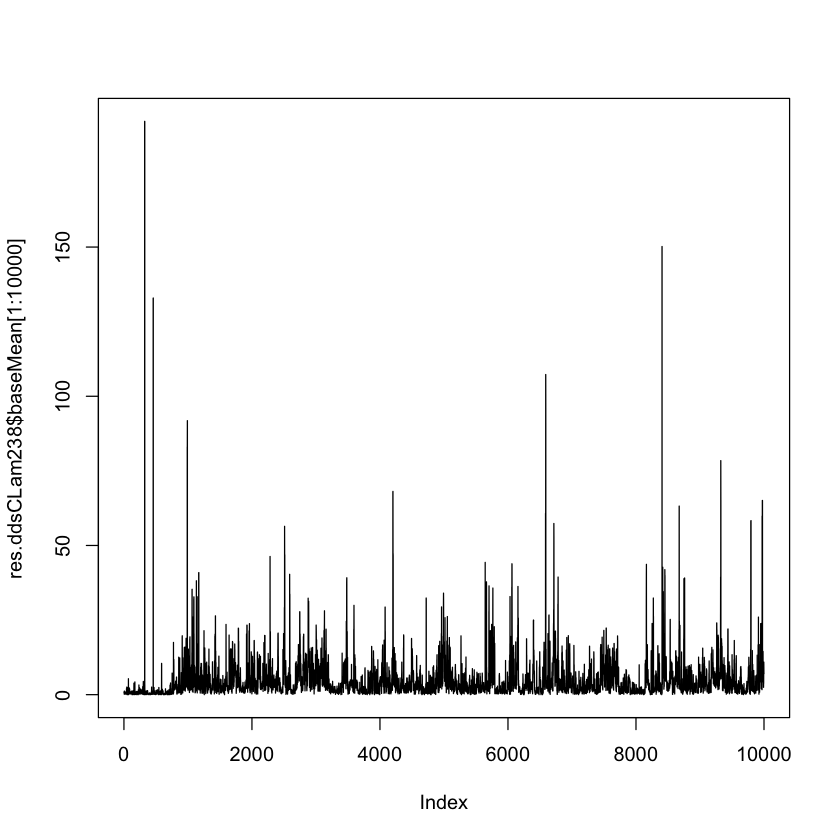

In [29]:
plot(res.ddsCLam238$baseMean[1:10000], type="l")

In [43]:
write.csv(res.ddsCLam238$log2FoldChange, file="Log2Fold_CLam238")
write.csv(res.ddsCLam238$baseMean, file="baseMean_CLam238")
write.csv(res.ddsCLam238, file="results_CLam238")


In [41]:
datasetCLam257 <- DESeqDataSetFromMatrix(countData = damid[,colsCLam257],
                                   colData = metadataCLam257,
                                   design = ~Protein)
suppressWarnings(ddsCLam257<-DESeq(datasetCLam257))

res.ddsCLam257<-results(ddsCLam257)

factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [44]:
#write.csv(res.ddsCLam257$log2FoldChange, file="Log2Fold_CLam257")
#write.csv(res.ddsCLam257$baseMean, file="baseMean_CLam257")
write.csv(res.ddsCLam257, file="results_CLam257")


In [47]:
datasetCLam188 <- DESeqDataSetFromMatrix(countData = damid[,colsCLam188],
                                   colData = metadataCLam188,
                                   design = ~Protein)
suppressWarnings(ddsCLam188<-DESeq(datasetCLam188))

res.ddsCLam2188<-results(ddsCLam188)

write.csv(res.ddsCLam188, file="results_CLam188")



factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


ERROR: Error in is.data.frame(x): object 'res.ddsCLam188' not found
